# Challenge based Learning : Try Python


## STEP 1 import modules and load the Data

In [1]:
# Import libraries
import laspy
from whitebox import WhiteboxTools
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from scipy import stats

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
#load_ext rpy2.ipython # first time only
%load_ext rpy2.ipython



In [2]:
%%R

library(lidR)
library(raster)
library(sp)

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 
lidR 4.0.3 using 4 threads. Help on <gis.stackexchange.com>. Bug report on <github.com/r-lidar/lidR>.
Loading required package: sp

Attaching package: ‘raster’

The following objects are masked from ‘package:lidR’:

    projection, projection<-

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/share/R/library’ contains no packages


In [3]:
#Load Data 
las = laspy.read("/home/nibe/PROJECTS/golm_tree_analysis/data/Golm_May06_2018_Milan_UTM33N_WGS84_6digit_cl.las")

# SOME TESTING DO NOT RUN 

In [22]:
ground_points = las.classification == 1
bins, counts = np.unique(las.return_number[ground_points], return_counts=True)

#DEBUG - Verification
print('Ground Point Return Number distribution:')
for r,c in zip(bins,counts):
    print('    {}:{}'.format(r,c))
print(len(las.return_number)) # 
print(len(ground_points))

Ground Point Return Number distribution:
    1:477040
    2:50287
    3:7336
    4:1153
    5:59
    6:3
10965500
10965500


# FROM HERE ALL IS FINE except if noted

In [4]:
with laspy.open('/home/nibe/PROJECTS/golm_tree_analysis/data/Golm_May06_2018_Milan_UTM33N_WGS84_6digit_cl.las') as f:
         print(f"Point format: {f.header.point_format}")
         print(f"Number of points: {f.header.point_count}")
         print(f"Number of VLRs: {len(f.header.vlrs)}")

Point format: <PointFormat(3, 0 bytes of extra dims)>
Number of points: 10965500
Number of VLRs: 2


In [26]:

filtered_points = las.points[(las.classification != 6) & (las.classification != 2)]
# Now you can calculate z-scores and filter these 'Z' values as before

len(filtered_points)


2968614

In [6]:
new_las = laspy.LasData(las.header)
new_las.points = filtered_points.copy()
new_las.write('../data/no_buildings_filtered_data.las')

# DO NOT RUN 

In [ ]:
##### DO NOT RUN .... TESTING 


# Open the original LAS file
#inFile = laspy.read("/home/nibe/PROJECTS/golm_tree_analysis/data/Golm_May06_2018_Milan_UTM33N_WGS84_6digit_cl.las")

# Filter out ground points
#ground_points = inFile.points[inFile.return_num == 3]

# Create a new LAS file with the filtered points
#filtered_las = laspy.read("/home/nibe/PROJECTS/golm_tree_analysis/app/test_filtered_data.las")
#filtered_las.points = ground_points

#len(filtered_las)

#filtered_las.write('test2_filtered.las')

In [7]:
%%R
library(lidR)
las <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/no_buildings_filtered_data.las", select = "xyzr")

# next segment trees ... may take a while!

In [9]:
%%R
las <- segment_trees(las, li2012(dt1 = 1.5, dt2 = 2, R = 2, Zu = 15, hmin = 2, speed_up = 2))

In [10]:
%%R
# Point-to-raster 2 resolutions
chm_p2r_05 <- rasterize_canopy(las, 0.5, p2r(subcircle = 0.2), pkg = "terra")
chm_p2r_1 <- rasterize_canopy(las, 1, p2r(subcircle = 0.2), pkg = "terra")
chm_p2r_2 <- rasterize_canopy(las, 2, p2r(subcircle = 0.2), pkg = "terra")
chm_p2r_3 <- rasterize_canopy(las, 3, p2r(subcircle = 0.2), pkg = "terra")

In [11]:
%%R
# Post-processing median filter
kernel <- matrix(1, 3, 3)
chm_p2r_05_smoothed <- terra::focal(chm_p2r_05, w = kernel, fun = median, na.rm = TRUE)
chm_p2r_1_smoothed <- terra::focal(chm_p2r_1, w = kernel, fun = median, na.rm = TRUE)
chm_p2r_2_smoothed <- terra::focal(chm_p2r_2, w = kernel, fun = median, na.rm = TRUE)
chm_p2r_3_smoothed <- terra::focal(chm_p2r_3, w = kernel, fun = median, na.rm = TRUE)

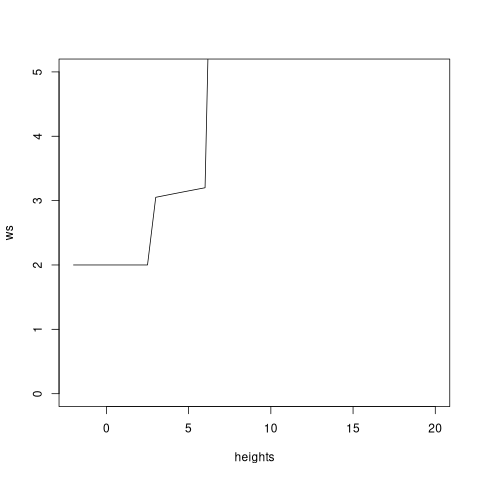

In [12]:
%%R
f <- function(x) {
  y <- 2.6 * (-(exp(-0.02*(x-2)) - 1)) + 3
  y[x < 3] <- 2
  y[x > 6] <- 9
  return(y)
}

heights <- seq(-2,20,0.5)
ws <- f(heights)
plot(heights, ws, type = "l",  ylim = c(0,5))

In [13]:
%%R
#P@R ORIGINAL
ttops_chm_p2r_05 <- locate_trees(chm_p2r_05, lmf(f))
ttops_chm_p2r_1 <- locate_trees(chm_p2r_1, lmf(f))
ttops_chm_p2r_2 <- locate_trees(chm_p2r_2, lmf(f))
ttops_chm_p2r_3 <- locate_trees(chm_p2r_3, lmf(f))
# P2R SMOOTHED
ttops_chm_p2r_05_smoothed <- locate_trees(chm_p2r_05_smoothed, lmf(f))
ttops_chm_p2r_1_smoothed <- locate_trees(chm_p2r_1_smoothed, lmf(f))
ttops_chm_p2r_2_smoothed <- locate_trees(chm_p2r_05_smoothed, lmf(f))
ttops_chm_p2r_3_smoothed <- locate_trees(chm_p2r_1_smoothed, lmf(f))
# PITFREE
#ttops_chm_pitfree_05_1 <- locate_trees(chm_pitfree_05_1, lmf(f))
#ttops_chm_pitfree_05_2 <- locate_trees(chm_pitfree_05_2, lmf(f))

In [14]:
%%R
print("p2r")
print(nrow(ttops_chm_p2r_05))
print(nrow(ttops_chm_p2r_1))
print(nrow(ttops_chm_p2r_2))
print(nrow(ttops_chm_p2r_3))
print("p2r smoothed")
print(nrow(ttops_chm_p2r_05_smoothed))
print(nrow(ttops_chm_p2r_1_smoothed))
print(nrow(ttops_chm_p2r_2_smoothed))
print(nrow(ttops_chm_p2r_3_smoothed))

[1] "p2r"
[1] 1469
[1] 1390
[1] 1193
[1] 1303
[1] "p2r smoothed"
[1] 1399
[1] 1282
[1] 1399
[1] 1282


[1] "tree count"
[1] 1469


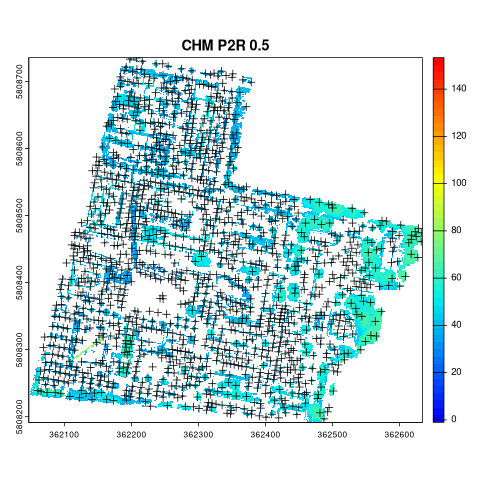

In [15]:
%%R

par(mfrow=c(1,1))
col <- height.colors(50)
# Reset the plot window size to default

plot(chm_p2r_05, main = "CHM P2R 0.5", col= col ); plot(sf::st_geometry(ttops_chm_p2r_05), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_p2r_05))


[1] "tree count"
[1] 1390


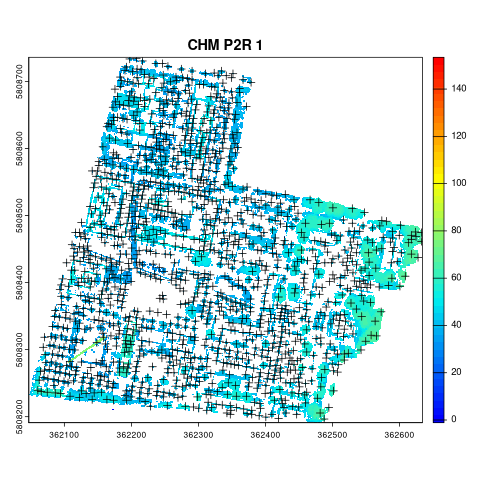

In [16]:
%%R
plot(chm_p2r_1, main = "CHM P2R 1", col = col); plot(sf::st_geometry(ttops_chm_p2r_1), add = T, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_1))


[1] "tree count"
[1] 1193


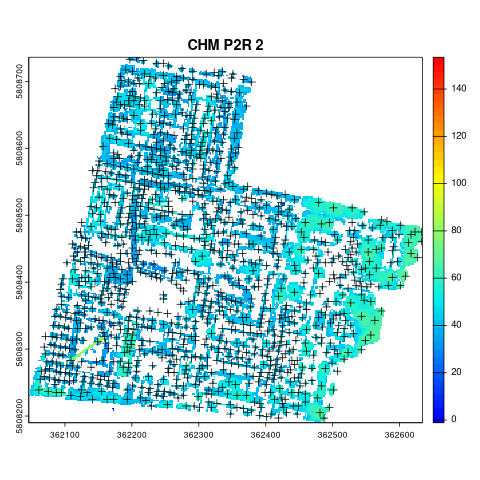

In [18]:
%%R
plot(chm_p2r_2, main = "CHM P2R 2", col= col ); plot(sf::st_geometry(ttops_chm_p2r_2), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_p2r_2))

[1] "tree count"
[1] 1303


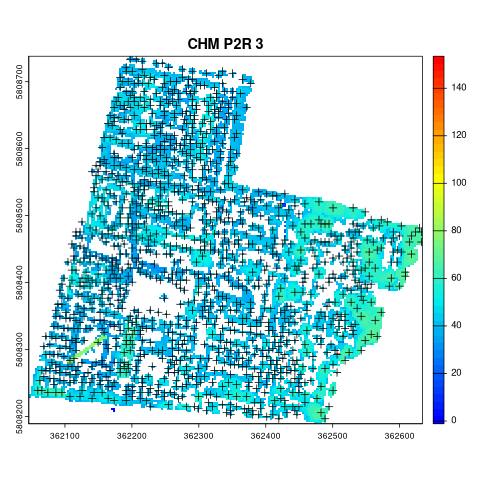

In [19]:
%%R
plot(chm_p2r_3, main = "CHM P2R 3", col= col ); plot(sf::st_geometry(ttops_chm_p2r_3), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_p2r_3))

[1] "tree count"
[1] 1399


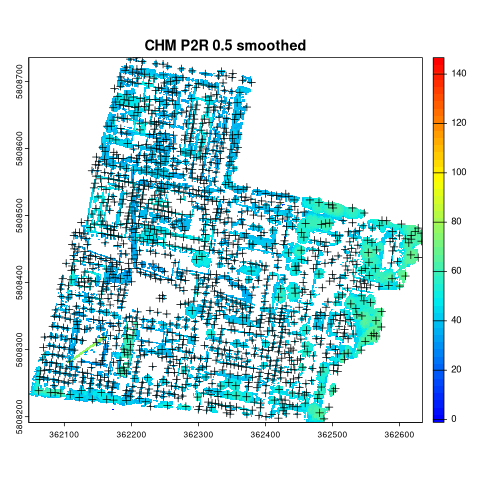

In [21]:
%%R 
plot(chm_p2r_05_smoothed, main = "CHM P2R 0.5 smoothed", col = col); plot(sf::st_geometry(ttops_chm_p2r_05_smoothed), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_p2r_05_smoothed))

[1] "tree count"
[1] 1282


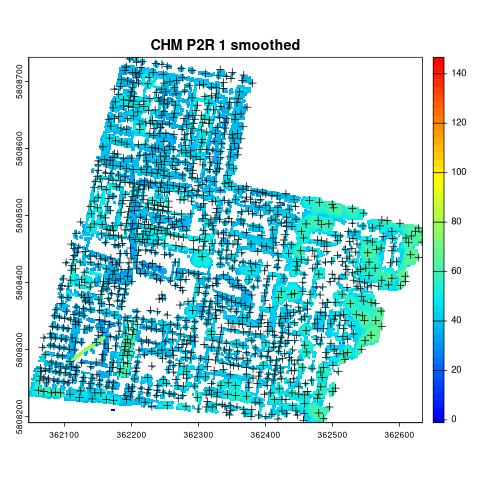

In [22]:
%%R
plot(chm_p2r_1_smoothed, main = "CHM P2R 1 smoothed", col = col); plot(sf::st_geometry(ttops_chm_p2r_1_smoothed), add = T, pch =3)
print("tree count")
print(nrow(ttops_chm_p2r_1_smoothed))

[1] 1399


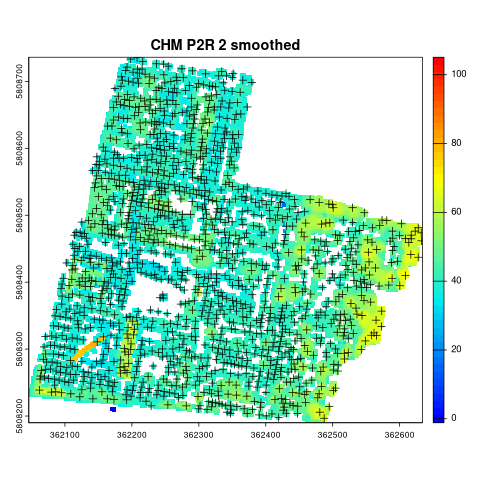

In [23]:
%%R 
plot(chm_p2r_2_smoothed, main = "CHM P2R 2 smoothed", col = col); plot(sf::st_geometry(ttops_chm_p2r_2_smoothed), add = T, pch =3)
print(nrow(ttops_chm_p2r_2_smoothed))


# PITFREE ALGORITHM

In [ ]:
%%R
plot(chm_pitfree_05_1, main = "CHM PITFREE 1", col = col); plot(sf::st_geometry(ttops_chm_pitfree_05_1), add = T, pch =3)


In [ ]:
%%R
plot(chm_pitfree_05_2, main = "CHM PITFREE 2", col = col); plot(sf::st_geometry(ttops_chm_pitfree_05_2), add = T, pch =3)